In [77]:
import typing as tp
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from collections import defaultdict


In [21]:
def rsign():
    return 1 if np.random.random() < 0.5 else -1

In [22]:
#prices
prices = {}

In [392]:
class RandomFeed:
    def __init__(self,
                 vol,
                 px: float,
                 #mid,
                 window: int,
                 dist_args=None,
                 distribution=np.random.normal,
                 **kwargs):
        '''Args:
            vol: volatility
            px: beginning px for history
            mid: the market id
            window: the length of the windowSize for TWAP
            dist_args: args that go into the distribution;
                for a gaussian, the center and the std
            
        '''

        self.distribution = distribution
        self.vol = vol
        self.px = px
        #self.id = mid
        self.window = window
        self.dist_args = (0,1)
        self.block_times = [0]
        self.cumul_px = [px]
        self.prices = [px]
        self.twaps = []
        self.returns = []
        self.kwargs = kwargs

    @staticmethod
    def block_time():
        # time it took to mine ith block in seconds
        return 13.23 + rsign()*np.random.rand()
    
    def get_returns(self, arr:np.array):
        # to get returns of any series
        arr_init = np.roll(arr, 1)
        returns = (arr/arr_init) - 1
        return returns[1:] #delete spurious return
    
    def get_twap(self, i:int, window=-1):
        if window < 0:
            window = self.window
        #ith block , window is number of blocks we average over
        if i < self.window:
            return
        else:
            return (self.cumul_px[i] - self.cumul_px[i - window])/window
    
    def update(self, modify_vol=False, **kwargs):      
        #WARNING!  an in-place method that mutates the class                                             
                                                     
        delta = self.get_delta(**kwargs)
        self.px += (self.vol * delta) 
        
        if self.px <= 0:
             raise Exception('the market price went to zero')
               
        block_time = t()
        
        #here we populate all the dynamic lists and 
        self.prices.append(self.px)
        self.cumul_px.append(self.cumul_px[-1] + block_time*self.px)
        self.block_times.append(block_time)
        self.returns.append(self.prices[-1]/self.prices[-2] - 1)
        
        if modify_vol:
            self.vol = kwargs['vol']

    def get_delta(self, **kwargs):
        #if the % moves are small relative to self.px, then the trader results will be unrealistic. 
        #px needs to move as a % of the price level to reflect compounding
        if kwargs.get('pct', False):
            standard_dev = self.vol*self.px/100   
            center = standard_dev/10  #self.dist_args[0]
            args = (center, standard_dev)
            delta = self.distribution(*args)  # if self.dist_args else self.distribution()    
        else:
            delta = self.distribution(*self.dist_args) if self.dist_args else self.distribution()
        delta = self.distribution(*self.dist_args) if self.dist_args else self.distribution()
        return delta  
    


In [393]:
np.random.seed(1)
markets = {
    0:RandomFeed(vol=1, px = 1e3, window=50, dist_args=(0, 1)),
    #1:RandomFeed(vol=1, px = 1e3, window=150, dist_args=(0, 1)),
    #2:RandomFeed(vol=1, px = 1e3, window=300, dist_args=(0, 1)),
    #3:RandomFeed(vol=1, px = 1e3, window=150, dist_args=(0, 1)),
    }
m = markets[0]
for _ in range(10000):
    m.update()

In [394]:
### test your get_returns method
rets = m.get_returns(m.prices)
all(map(np.isclose, m.returns, rets))

True

In [395]:
twaps = np.array([m.get_twap(i) for i in range(50,10000)])

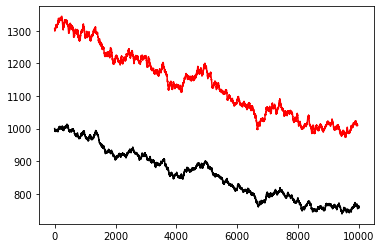

In [396]:
plt.plot(m.prices, c='k')
plt.plot(twaps/10, c='r')

# The TWAP and the spot price are very different numbers , what about the returns?

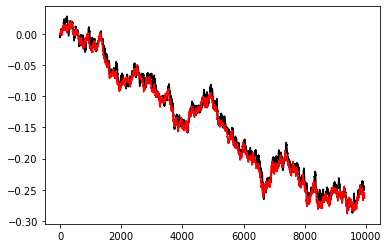

In [397]:
twap_crets = np.cumsum(m.get_returns(twaps))
crets = np.cumsum(m.returns[m.window:])

plt.plot(twap_crets, c='k')
plt.plot(crets, c='r')

# Zoom in

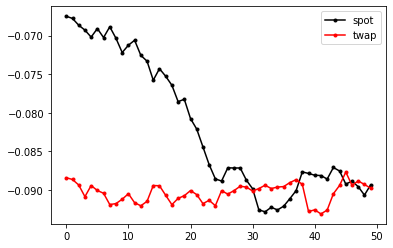

In [398]:
plt.plot(twap_crets[3000:3050], marker='.', c='k', label='spot')
plt.plot(crets[3000:3050], marker='.', c='r', label='twap')
plt.legend()

# Because of the averaging, there are arbitrage opportunities between spot and TWAP prices. How extreme are these opportunities? 

In [399]:
#on a block-by-block basis
twap_rets = m.get_returns(twaps)
ret_diff = m.returns[51:] - twap_rets
print(f'max + return difference: +{max(ret_diff)},\nmax - return difference: {min(ret_diff)}')
print('\n')
#buy and hold, waiting for divergence to get out
cret_diff = crets[1:] - twap_crets
print(f'max + cumulative return difference: +{max(cret_diff)},\nmax - cumulative return difference: {min(cret_diff)}')

max + return difference: +0.006291579746074194,
max - return difference: -0.00592785402338647


max + cumulative return difference: +0.02102752765466276,
max - cumulative return difference: -0.03517420471279564


# How does the TWAP change as we change the `windowSize`?

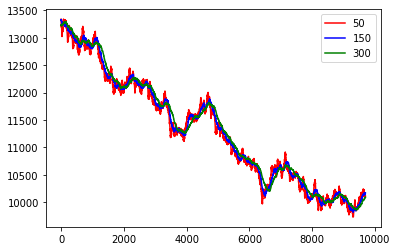

In [402]:
twaps = {}
for i in [50,150,300]: #different window sizes, 300 is approx 1 hr
    twaps[i] = np.array([m.get_twap(j, window=i) for j in range(i,10000)])
#plt.plot(m.prices[300:], c='k')
plt.plot(twaps[50][250:], c='r', label='50')
plt.plot(twaps[150][150:], c='b',label='150')
plt.plot(twaps[300], c='g',label='300')
plt.legend()

In [404]:
#they have different lengths,  be careful
list(map(len, twaps.values()))

[9950, 9850, 9700]

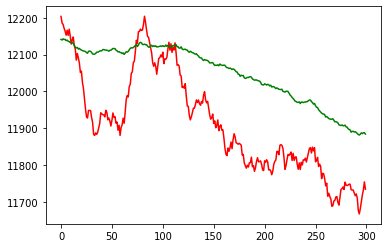

In [409]:
plt.plot(twaps[50][3000:3300], c='r', label='50')
plt.plot(twaps[300][2750:3050], c='g',label='300') #need to offset by 250 to align

In [410]:
twap_crets = np.cumsum(m.get_returns(twaps[300]))
crets = np.cumsum(m.returns[301:])

assert len(twap_crets) == len(crets)

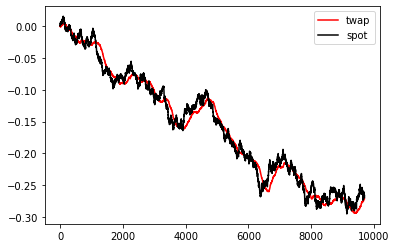

In [411]:
plt.plot(twap_crets, c='r', label='twap')
plt.plot(crets, c='k', label='spot')
plt.legend()

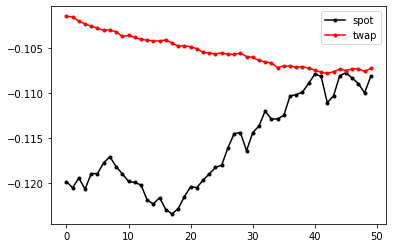

In [412]:
plt.plot(crets[3000:3050], marker='.', c='k', label='spot')
plt.plot(twap_crets[3000:3050], marker='.', c='r', label='twap')
plt.legend()

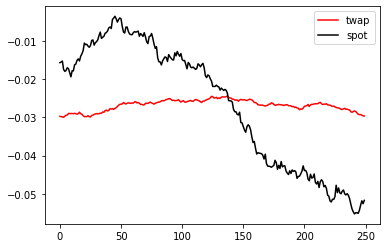

In [413]:
plt.plot(twap_crets[1000:1250], c='r', label='twap')
plt.plot(crets[1000:1250], c='k', label='spot')
plt.legend()

In [415]:
#on a block-by-block basis
twap_rets = m.get_returns(twaps[300])
ret_diff = m.returns[301:] - twap_rets
print(f'max + return difference: +{max(ret_diff)},\nmax - return difference: {min(ret_diff)}')
print('\n')
#buy and hold, waiting for divergence to get out
cret_diff = crets - twap_crets
print(f'max + cumulative return difference: +{max(cret_diff)},\nmax - cumulative return difference: {min(cret_diff)}')

max + return difference: +0.004872836628034949,
max - return difference: -0.004636973513953535


max + cumulative return difference: +0.0453587122216943,
max - cumulative return difference: -0.038057960141136826


# The main concern is that the TWAP can be predicted. Let's see if this is the case

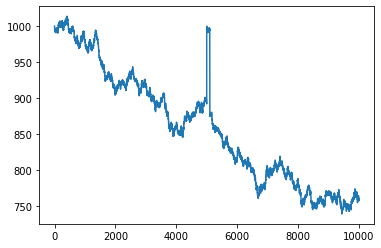

In [416]:
prices_w_shock = m.prices.copy()
shock_block = 5000
for i in range(100):
    prices_w_shock[shock_block + i] = prices_w_shock[i]  
plt.plot(prices_w_shock)

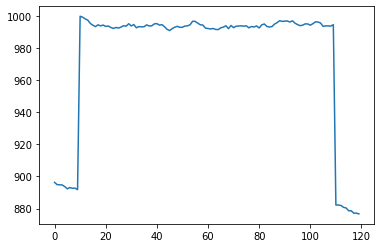

In [430]:
plt.plot(prices_w_shock[shock_block-10:shock_block+110])

In [418]:
import copy
Shock = copy.deepcopy(m)
window = 300
Shock.prices = prices_w_shock
Shock.returns = Shock.get_returns(np.array(prices_w_shock))
Shock.cumul_px = np.cumsum(list(map(np.multiply, Shock.block_times, Shock.prices)))
Shock_twaps = np.array([Shock.get_twap(j, window=window) for j in range(window,10000)])

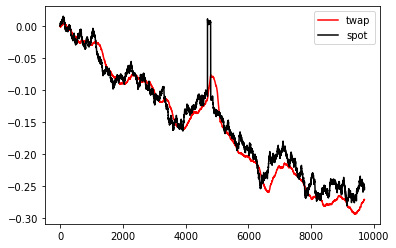

In [419]:
twap_crets = np.cumsum(Shock.get_returns(Shock_twaps))
crets = np.cumsum(Shock.returns[window:])

plt.plot(twap_crets, c='r', label='twap')
plt.plot(crets, c='k', label='spot')
plt.legend()

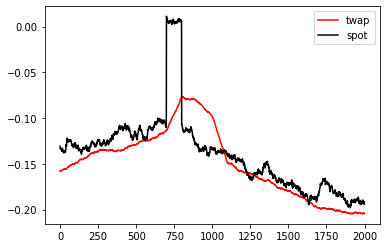

In [422]:
plt.plot(twap_crets[4000:6000], c='r', label='twap')
plt.plot(crets[4000:6000], c='k', label='spot')
plt.legend()

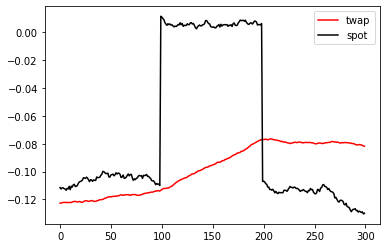

In [425]:
shock_time = shock_block-window

plt.plot(twap_crets[shock_time-100:shock_time+100+100], c='r', label='twap')
plt.plot(crets[shock_time-100:shock_time+100+100], c='k', label='spot')
plt.legend()

In [429]:
(twap_crets[shock_time+100] -twap_crets[shock_time]) 

0.035857625595267506

# A 10% shock occuring in 10 blocks (a couple minutes) and lasting for 100 blocks (20 minutes) leads to about 3.5% of free profit for anyone paying attention. What is worse is that, because of the time delay, the price does not immediately revert when the spot price has an opposite shock. 